# Distributional and frequency effects in word embeddings: Similarity stratification
## © 2018 Chris Culy, June 2018, revised 10 July 2018
### [chrisculy.net](http://chrisculy.net/)

## Overview
This is one of a [series of posts](dist_freq_intro.html). In this post I look at what I call _stratification_ of similarities and ranks, as well the "reciprocity" of ranks (how close the ranks are when we swap the reference and the comparison). What we observe is that in many cases the similarity (or rank) of two words is related to their relative frequencies. 

While [[1]](#ref1) noticed a related phenomenon, which I'll turn to in the [next post](dist_freq_vecs.html), I believe this is the first time that stratification of similarities and ranks has been noticed.

### Results and contributions

* **new** Stratification of similarities
    - for sgns and ft, frequency is _inversely_ related to similarity
    - for glove and ppmi frequency is _directly_ related to similarity
* **new** Stratification of rank
    - for all models, the frequency of the _reference_ term is somewhat _directly_ correlated to rank
    - for sgns and ft, the frequency of the _comparison_ term is _inversely_ related to to rank
    - for glove and ppmi, the frequency of _comparison_ term is _inversely_ related to to rank
    - for glove and ppmi, there is a smaller difference between reference and comparison terms than with sgns and ft
* **new** Stratification of reciprocity
    - for sgns and ft, words with similar relative frequencies are more reciprocal than words with different relative frequencies
    - for glove, there is general reciprocity, except when one word is very low frequency
    - ppmi patterns more with sgns and ft than with glove, contrary to expectations based on rank
* **new** Behavior with respect to corpora for rank and reciprocity
    - ft, glove, and ppmi behave similarily for both corpora
    - sgns behaves differently the corpora, patterning with ft for vfair, but with glove and ft for heartd


[Download as Jupyter notebook](dist_freq_stratification.ipynb)

[Download supplemental Python code](dfewe.zip)

<input type="checkbox" id="toggleCheck" checked> Show Code

In [1]:
#imports
from dfewe import *

#for tables in Jupyter
from IPython.display import HTML, display
import tabulate

In [2]:
# some utilities
def show_title(t):
    display(HTML('<b>%s</b>' % t))

def show_table(data,headers,title):
    show_title(title)
    display(HTML(tabulate.tabulate(data,tablefmt='html', headers=headers)))

In [3]:
#set up standard corpora + vectors
vfair_all = Setup.make_standard_sampler_and_vecs('vfair',5,100,1) #window=5, dims=100, min_count=1
heartd_all = Setup.make_standard_sampler_and_vecs('heartd',5,100,1) #window=5, dims=100, min_count=1

what = [['Vanity Fair (vfair)'],['Heart of Darkness (heartd)']]
for i,c in enumerate([vfair_all,heartd_all]):
    sampler = c['sampler']
    what[i].extend([sum(sampler.counts.values()), len(sampler.counts)])

show_table(what, headers=['Corpus','Tokens','Types'], title="Corpora sizes")

## Stratification of similarities

We saw in the [previous post](dist_freq_sim_shift.html) that removing low frequency words lowered the mean of the similarities. That means that low frequency words contribute higher than average similarities. We can look for a broader relation between word frequency and similarities by looking at the mean similarity of words by their relative frequencies. Below we have a heatmap showing the mean similarities by percentile bands for sgns vectors from _Vanity Fair_ (vfair). The darker the square, the higher the mean similarity for words in the corresponding percentil bands. For example, pairs of words both in the 0-5 percentile band have a mean similarity of over 0.9, while pairs words in the 0-5 percentile band and the 85-90 percentile band have a mean similarity of about 0.55.

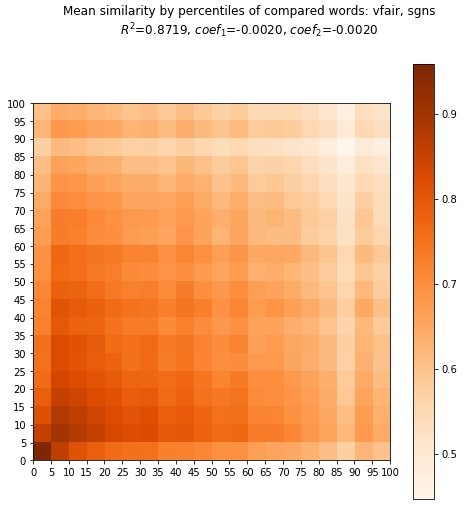

In [4]:
samples = 1000
step = 5
Plotting.show_range_comparison(vfair_all['sampler'],vfair_all['sgns'],'vfair, sgns',samples=samples,step=step, full_range=False)

While there is a particular anomaly in the 85-90 percentile band, and a few other small anomalies, what we see is that _overall_ the colors get lighter from left to right and from bottom to top. That means that _overall_ the pattern is that comparing word **w** to a lower frequency word will give a higher similarity than comparing **w** to a higher frequency word. In other words, frequency is _inversely_ related to similarity for these vectors, which we can also see by the negative coefficients of the linear regression.

Let's compare all 4 methods for vfair.

<span id="vfair_strat1"></span>

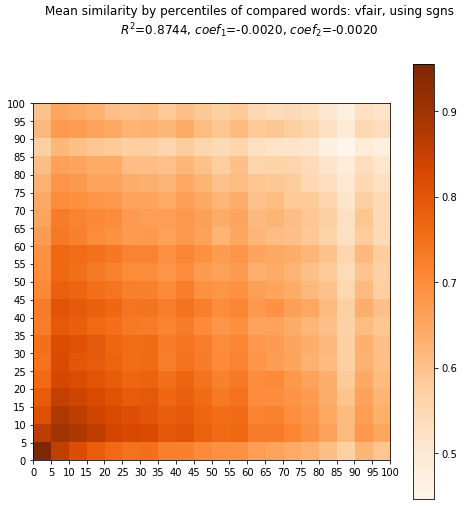

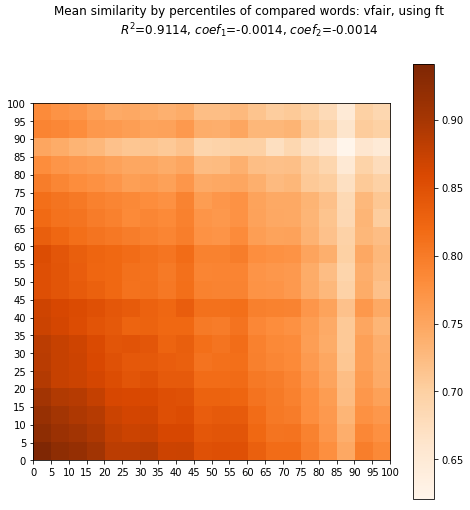

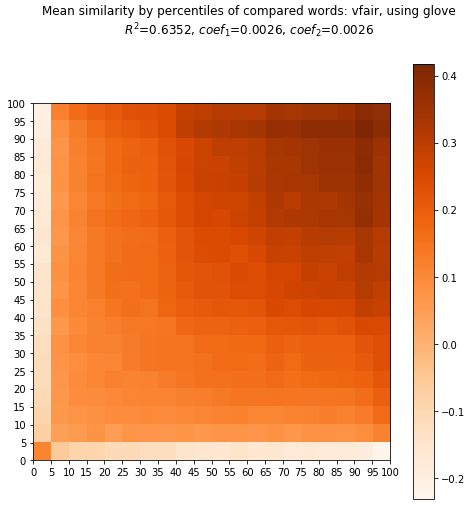

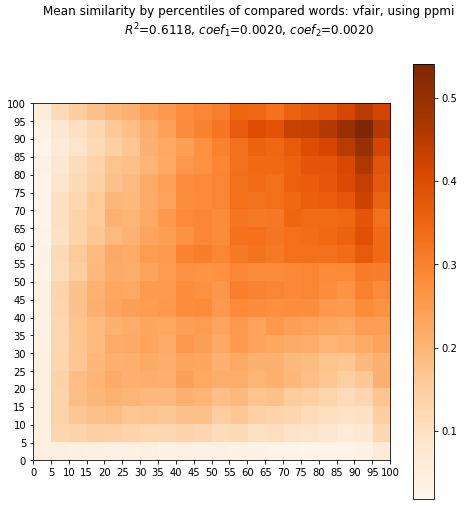

In [5]:
samples = 1000
step = 5
Plotting.compare_range_comparisons(vfair_all,'vfair',samples=samples, step=step, full_range=False)

The most striking thing to notice in comparing the four methods is that sgns and ft have similar patterns, but glove and ppmi have the _opposite_ pattern. So while for sgns and ft frequency is _inversely_ related to similarity, for glove and ppmi frequency is _directly_ related to similarity (with positive coefficients in the regression). Note that this difference cannot be attributed simply to the differences in overall means that we saw in the [previous post](dist_freq_sim_shift.html): it is logically/mathematically possible to have the inverse relation with a low average mean and a direct relation with a high average mean.

As in our first example with sgns, there are various anomalies. In addition, glove and ppmi have a strong anomaly in the 90-95 percentile band, whereas for sgns and ppmi the (corresponding?) anomaly is in the 85-90 percentile band.

Now let's do the same comparison, but using _Heart of Darkness_ (heartd).

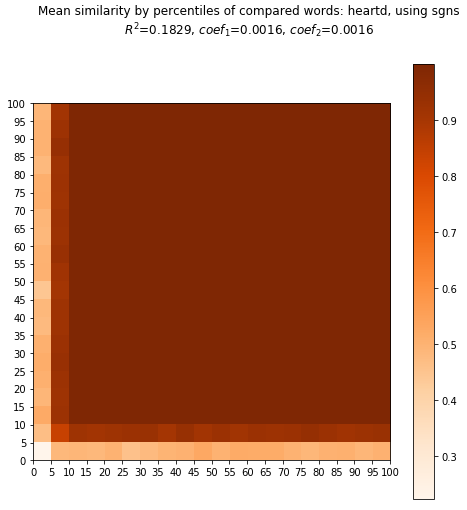

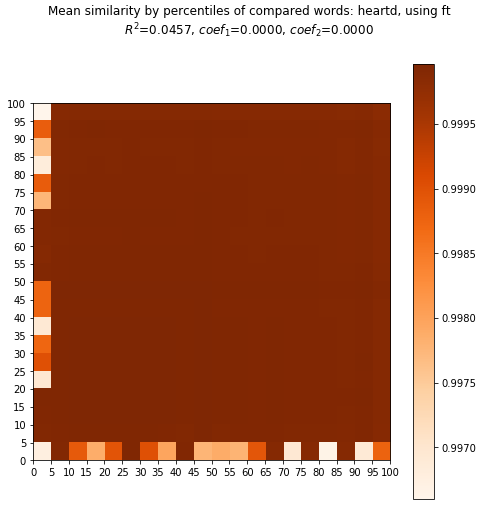

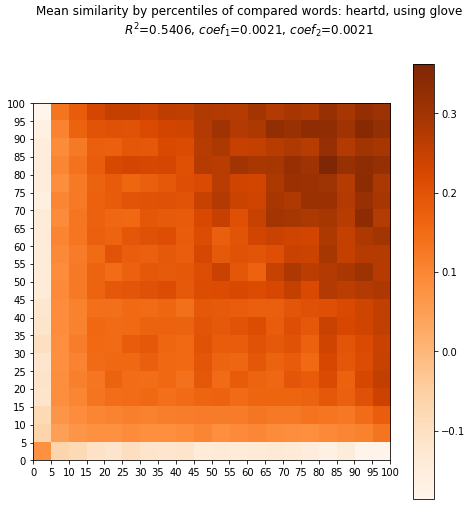

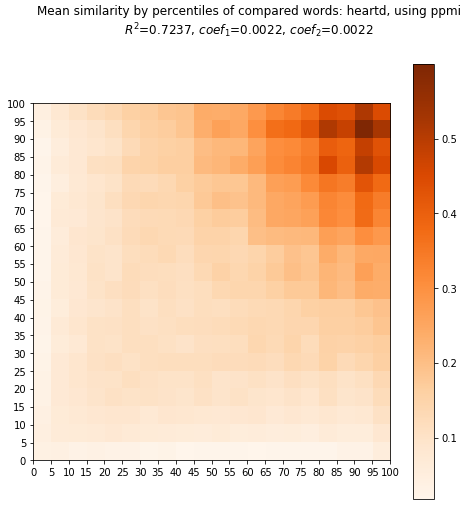

In [6]:
samples = 1000
step = 5
Plotting.compare_range_comparisons(heartd_all,'heartd',samples=samples, step=step, full_range=False)

What we see is that sgns and ft do not discriminate well for _Heart of Darkness_, but this is not surprising given the overall distributions that we saw in the [previous post](dist_freq_sim_shift.html). We also see that glove and ppmi have similar (though attenuated) patterns for both texts. This suggests that the relations between frequency and similarity are properities of the methods rather than of the texts. Of course, this would need to be verified by looking at more corpora.

## Stratification of ranks

Often we are interested in the _rank_ of a word with respect to another word rather than their similarity. An important thing about rank is that is not, in general, symmetric, unlike similarity.

In [7]:
vecs = vfair_all['sgns']
(word1, word2) = ('lady','woman')
print('Similarity of "%s" and "%s": %0.4f' % (word1,word2,vecs.similarity(word1,word2)))
print('Rank of "%s" with respect to "%s": %d' % (word1,word2,vecs.rank(word1,word2)))
print('Rank of "%s" with respect to "%s": %d' % (word2,word1,vecs.rank(word2,word1)))

Similarity of "lady" and "woman": 0.6593
Rank of "lady" with respect to "woman": 409
Rank of "woman" with respect to "lady": 8072


Again, let's start with a look at the sgns vectors for vfair. In these heatmaps, the "reference" word is the "with respect to" word, and the comparison is the other word. So in the first example above, the rank of _lady_ with respect to _woman_, _woman_ is the reference and _lady_ is the comparison. Note too that I'm using _relative_ rank in order to be able to compare vocabularies of different sizes (e.g. vfair vs heartd).

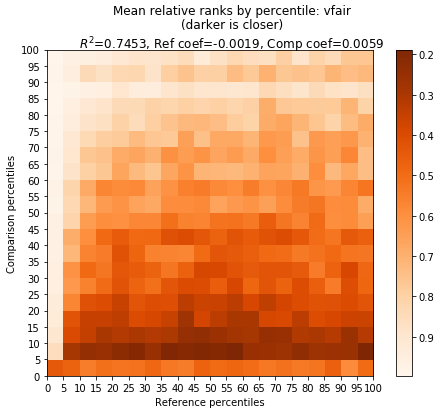

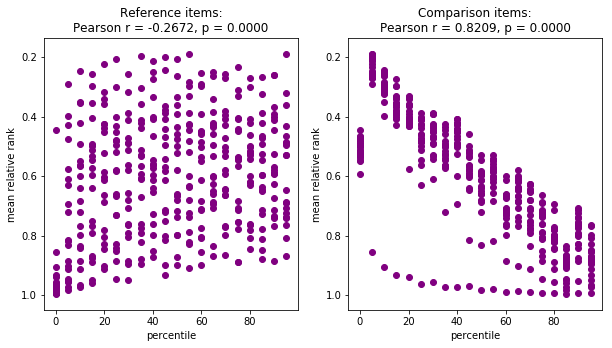

In [8]:
sampler = vfair_all['sampler']
vecs = vfair_all['sgns']
samples = 100 #fewer, because this is slow
step = 5
Plotting.show_relrank_comparison(sampler,vecs,'vfair',samples=samples,step=step, full_range=False)

We can see in the heatmap above that in contrast to the similarities, the mean relative ranks is _not_ symmetrical. However, there are patterns concerning relative frequency. 

But first a note about terminology. When we talk about a "high ranking" item it means the items has a _low_ numeric rank &mdash; language is odd. A consequence is that the sign of the Pearson correlation is the _opposite_ of how we talk about rank: it is positive when _high_ frequency is correlated with large _numeric_ rank which is low _conceptual_ rank. So if frequency is _directly_ correlated with _numeric_ rank, it is _inversely_ correlated _conceptual_ rank. In talking about the direction of correlation, I will use _conceptual_ rank. I've also arranged the rank values in the scatter plots so that the high ranking (i.e. low numeric value) items are towards the top of the chart.

Getting back to the data, what we see is that the frequency of the _comparison_ term is _inversely_ related  to rank: we have darker cells in the bottom of the heatmap, and the scatterplot for the comparison items (underneath on the right) shows a strong _inverset_ correlation with percentile. In other words, the higher the relative frequency of the comparison term, the lower its relative rank. So, a low frequency word would be ranked closer to a given word than a high frequency word would.

The pattern with _reference_ terms is weaker, and in the opposite direction: there is somewhat of a _direct_ relation between reference terms and rank.

Here are all four methods for vfair.

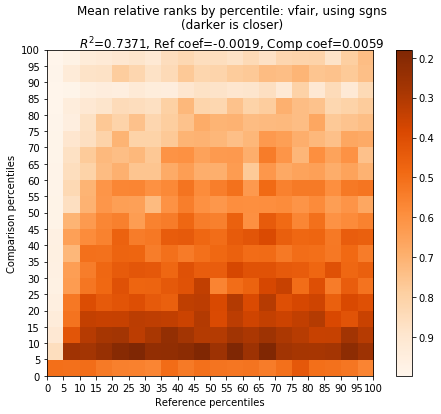

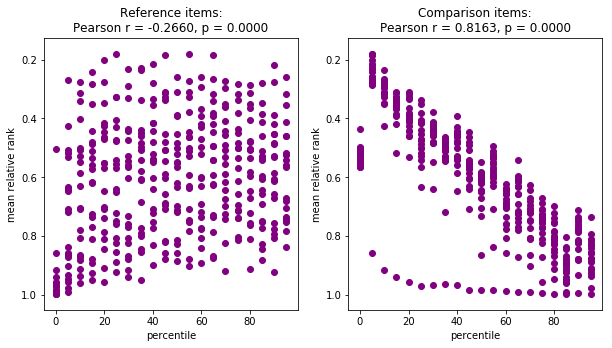

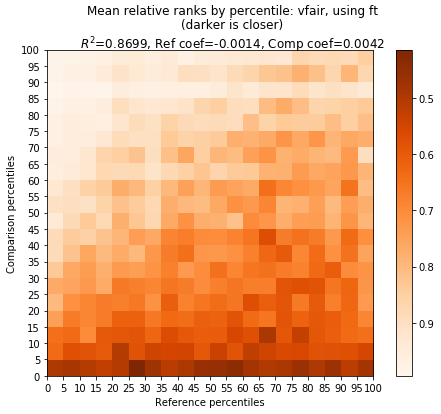

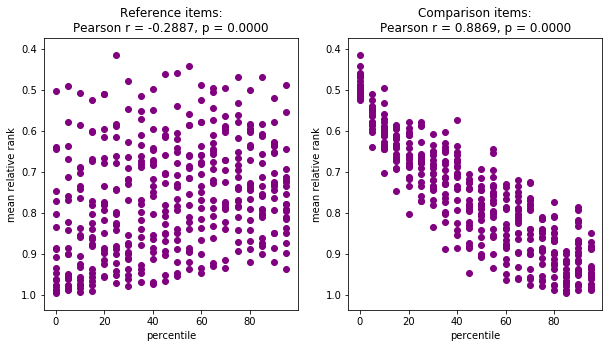

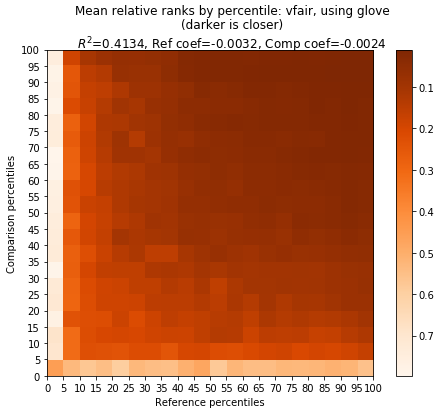

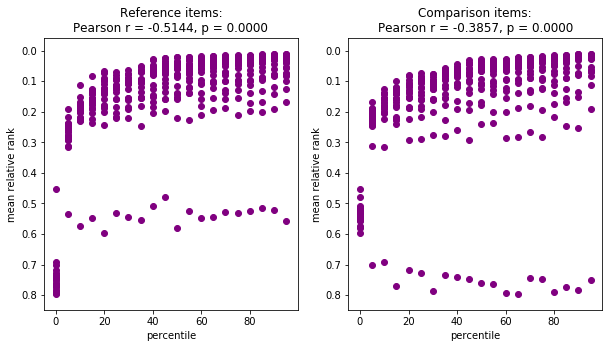

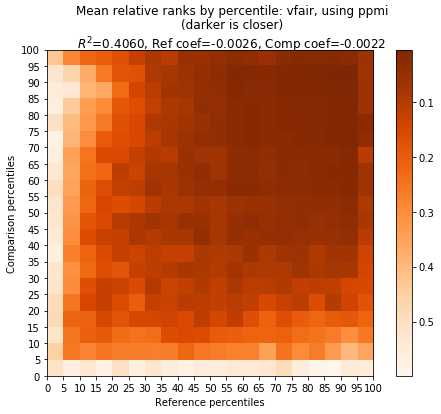

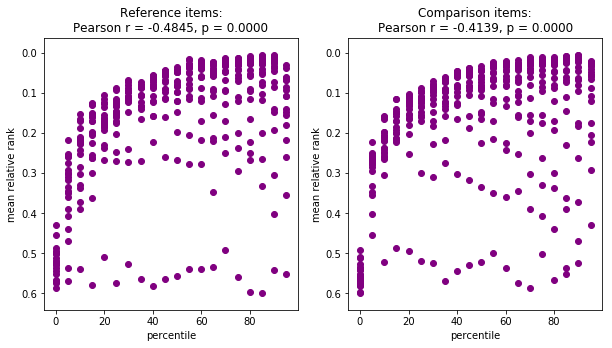

In [9]:
samples = 100 #fewer, because this is slow
step = 5
Plotting.compare_relrank_comparisons(vfair_all,'vfair', samples=samples, step=step, full_range=False)

There are three main things to notice in those examples. The first thing is that once again the sgns and ft models are similar to each other, and the glove and ppmi models are also similar to each other. The difference is that for glove and ppmi, the comparison terms have _direct_ correlation between frequency and rank, unlike for sgns and ft. 

The second thing is that reference terms have somewhat of a _direct_ correlation between frequency and rank, _across all 4 models_.

The third thing is that the glove/ppmi pattern shows smaller differences between the reference and comparison results than does the sgns/ft patten. This suggests that in the glove and ppmi models, rank is in fact somewhat reciprocal.

We can examine reciprocity in more detail by looking at the magnitude of the difference in relative ranks when comparing $word_1$ and $word_2$ and vice versa. What do we expect? In geometric terms of the heatmaps above, what we are doing is comparing (by reflection across the diaganol of reference percentile = comparison percentile) the upper left diagonal with the lower right diagonal. The more alike the two halves are, the more reciprocal rank is. The two halves of sgns and ft are very different, so we expect a strong relation between frequency and reciprocity). On the other hand, the two halves of glove are very similar, so we expect litle relation between frequency and reciprocity. The two halves of ppmi are also similar, though not as similar as in the case of glove, so we might expect some kind of relation between reciprocity and frequency.

In fact, our expectations are mostly born out in the charts below. A dark diagonal from lower left to upper right compared to lighter other areas shows that items with similar frequencies (the ones near the diagonal) are more reciprocal than items with differing frequencies (the ones away from the diagonal). In other words, the reciprocity is _limited_ to items of similar frequency. We see this pattern fairly clearly with sgns and ft, and we get pretty strong correlation (seen in the scatter plots) between frequency and reciprocity, as we predicted.

For glove, there is no pattern along the diagonal, and the correlation between frequency and reciprocity is low (~ 0.3), also as we expected. The one anomaly is that the lowest frequency items show less reciprocity than other items

The case of ppmi is a more puzzling, since there is somewhat of a dark diagonal, and there is a correlation between frequency and reciprocity is very similar to that for ft (~ 0.75 vs ~0.76). Visually, the heatmap and scatterplot for ppmi is different from that from sgns/ft, so this pattern deserves more attention, more than I can give here.

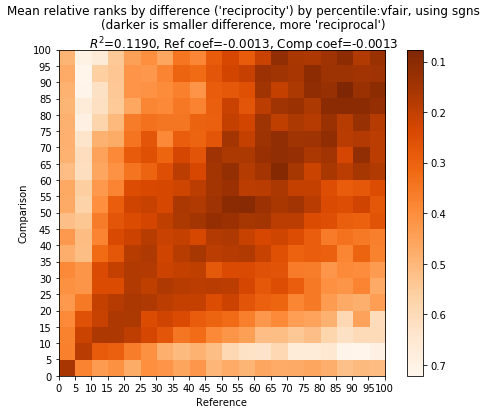

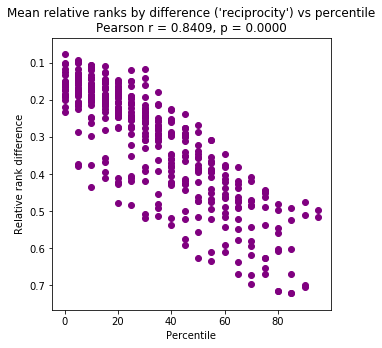

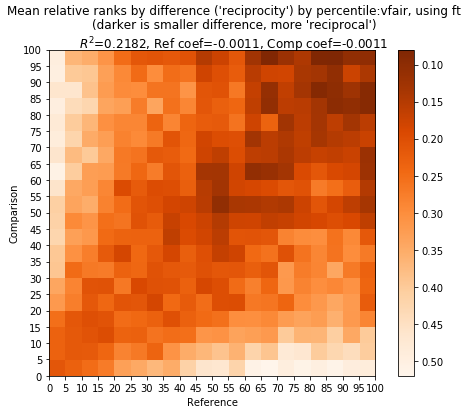

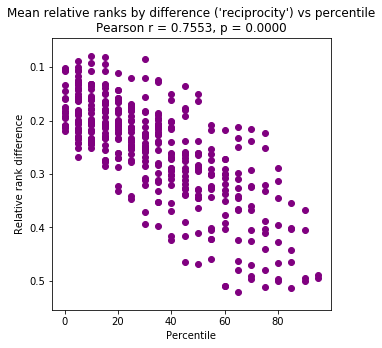

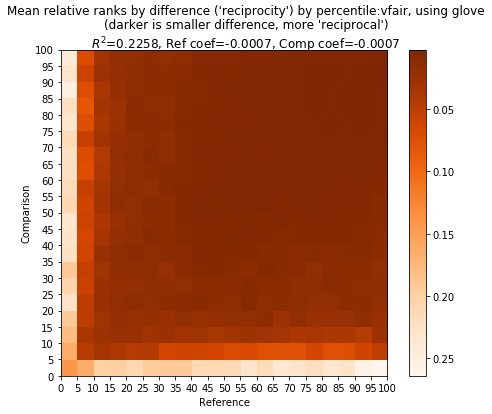

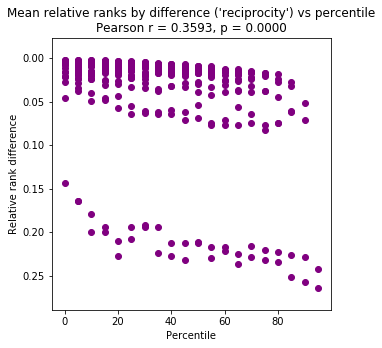

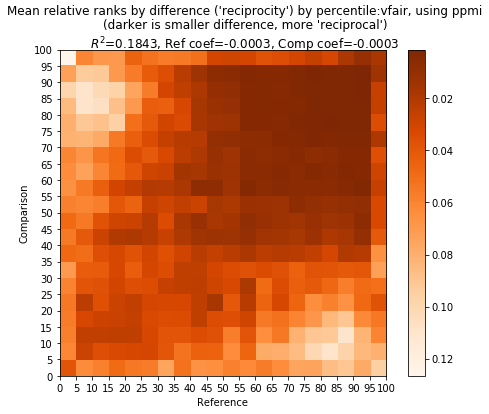

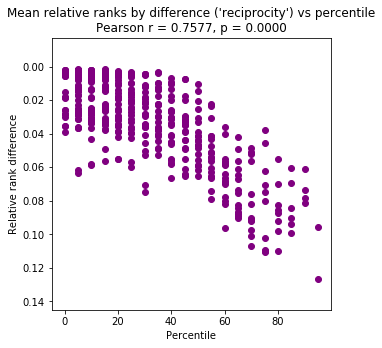

In [10]:
samples = 100 #fewer, because this is slow
step = 5
Plotting.compare_recip_rank_comparisons(vfair_all,'vfair',samples=samples,step=step,full_range=False)

Now let's see what happens with ranks in heartd.

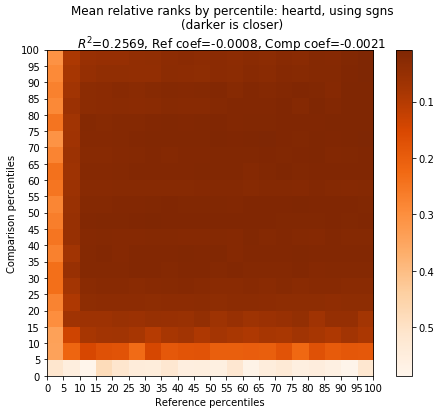

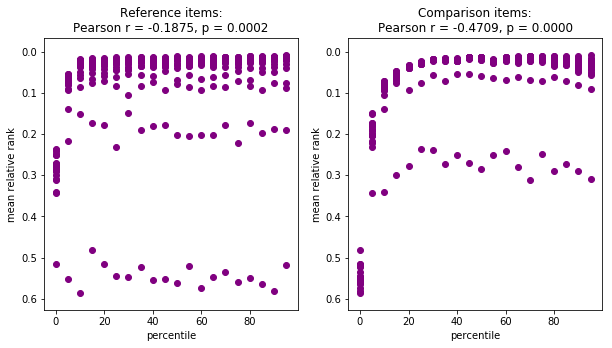

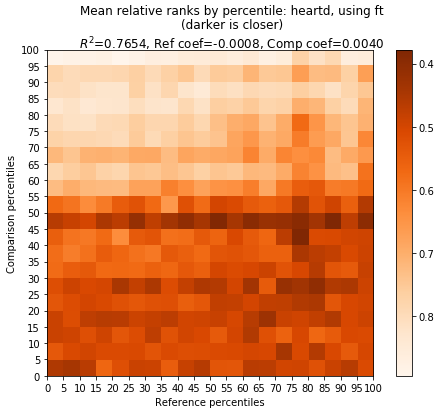

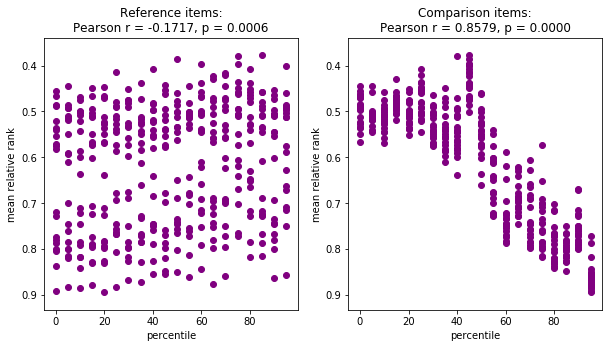

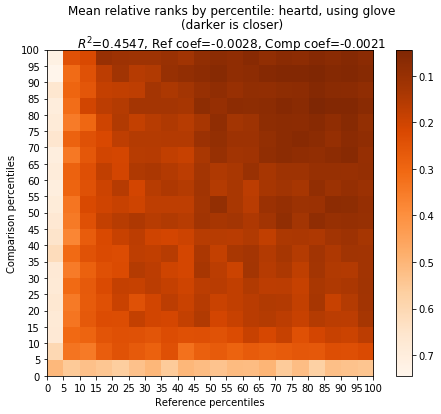

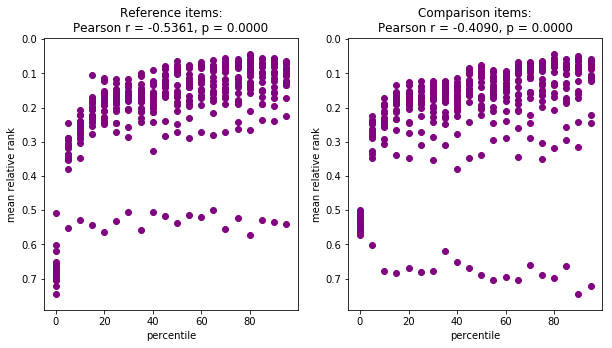

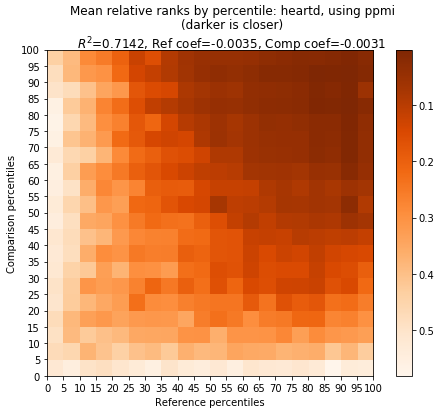

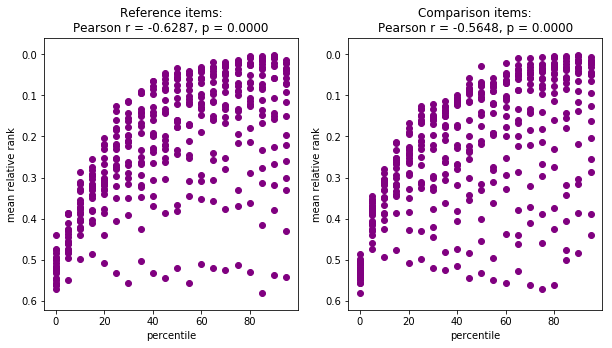

In [11]:
samples = 100 #fewer, because this is slow
step = 5
Plotting.compare_relrank_comparisons(heartd_all,'heartd', samples=samples, step=step, full_range=False)

The main thing to notice is that while ft, glove, and ppmi behaver similarly on heartd as they do on vfair, sgns behaves very differently across the two corpora. In particular, on heartd sgns patterns more like glove and ppmi and less like ft, with a slight a slight inverse correlation between frequency and rank.

Given this change in sgns' pattern, we expect its reciprocity pattern to change as well, to one with little correlation between reciprocity and frequency. This is borne out.

We also expect ft to have some correlation between reciprocity and frequency and glove to have little correlation, as with vfair. This is borne out fairly well (glove's correlation is ~ 0.38)

As for ppmi, looking at the heatmap above, we see that the upper left and lower right diagonals are similar, so we expect _little_ correlation between reciprocity and frequency. This is _not_ borne out, and so as before, ppmi remains somewhat of a puzzle.

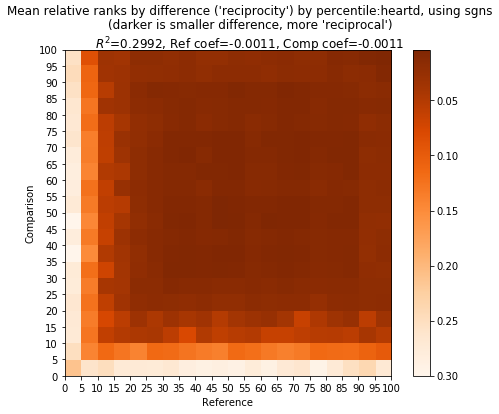

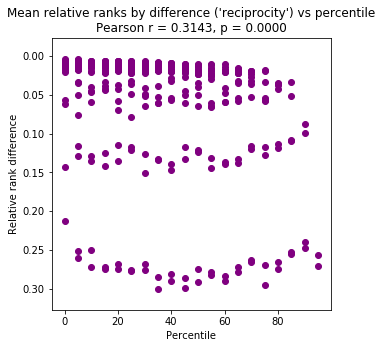

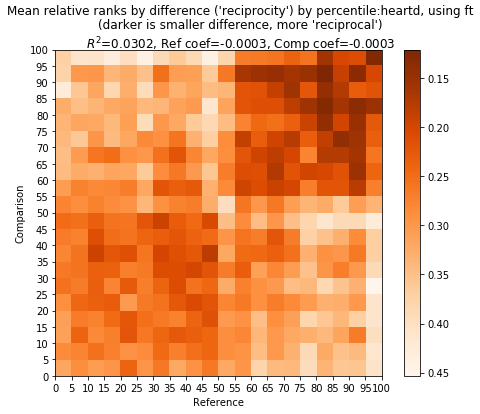

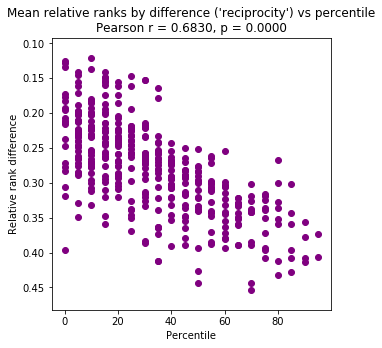

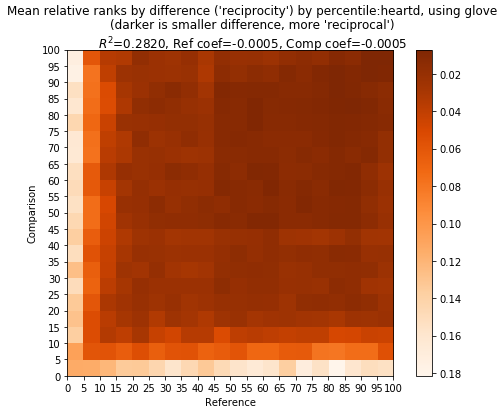

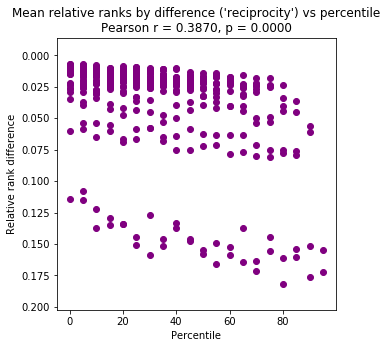

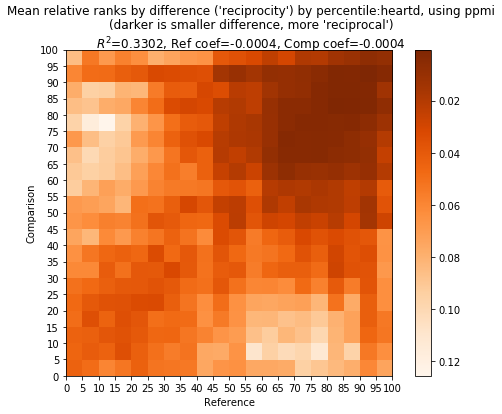

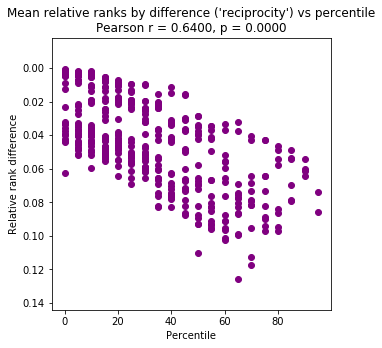

In [12]:
samples = 100 #fewer, because this is slow
step = 5
Plotting.compare_recip_rank_comparisons(heartd_all,'heartd',samples=samples,step=step,full_range=False)

## Summary

In this section, we've seen sgns and ft patterning together, as they did for the overall similarity distributions. However, here, sgns and ft did not always pattern together, parting ways on heartd. Similarly, glove and ppmi patterned together to a certain extent, as before. The mystery here is ppmi's divergence.

The fact that there are two different patterns means that the relationship between word frequencies and similarities or ranks is not an inherent aspect of language (or vectors). The fact that sgns has different patterns for the two corpora means that the relationship between frequencies and rank/reciprocity is not an inherent aspect of sgns, but somehow connected to the corpus.

The fundamental question we are left with is how these different effects arise across methods and across corpora.

[Back to the introduction](dist_freq_intro.html)


## The posts

* [Shifted similarity distributions](dist_freq_sim_shift.html)
* ➤ Similarity stratification
* [Frequency effects of vectors](dist_freq_vecs.html)
* [Strange geometry](dist_freq_geometry.html)
* [Distributional effects and hubs](dist_freq_hubs.html)
* [Recapitulation and next steps](dist_freq_recapit.html)

## References

<span id="ref1">[1]</span> Tobias Schnabel, Igor Labutov, David Mimno, and Thorsten Joachims. 2015. Evaluation methods for unsupervised word embeddings. Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing.

